# Building a deep cervical cell classifier using transfer learning

## Introduction

### Analysis outline


This notebook describes how to build a deep learning classifier that can classify cell status from papsmear images. 

We will create and train a deep learning classifier using a transfer learning approach. First we will establish a base classifier model using pretrained weights and network architecture from the Xception model  **[Chollet, 2017]**. To further fine-tune this base classifier, we will add a new top layer to the Xception model, which we subsequently will train on the SIPakMed data set **[Plissiti et al., 2018]** while freezing the original weights in the other layers of the Xception model. Additionally, we will perform hyper parameter tuning to find the best hyperparameters for the top layer. After finding a model with optimal hyperparameters, we will fine-tune the network further by unfreezing the pretrained weights in the Xception layer. We will use a very small learning rate when fine-tuning the model to avoid overfitting.




### The SIPaKMeD data set


**The SIPaKMeD data set** [https://www.cs.uoi.gr/~marina/sipakmed.html](https://www.cs.uoi.gr/~marina/sipakmed.html) consists of 4049 images of isolated cells that have been manually cropped from 966 cluster cell images of Pap smear slides. These images were acquired through a CCD camera adapted to an optical microscope. The cell images are divided into five categories containing normal, abnormal and benign cells (descriptions taken from the SIPaKMeD website ):

1. **Superficial-Intermediate cells** constitute the majority of the cells found in a Pap test. Usually they are flat with round, oval or polygonal shape cytoplasm stains mostly eosinophilic or cyanophilic. They contain a central pycnotic nucleus. They have well defined, large polygonal cytoplasm and easily recognized nuclear limits (small pycnotic in the superficial and vesicular nuclei in intermediate cells). These type of cells show the characteristics morphological changes (koilocytic atypia) due to more severe lessions.

2. **Parabasal cells** are immature squamous cells and they are the smallest epithelial cells seen on a typical vaginal smear. The cytoplasm is generally cyanophilic and they usually contain a large vesicular nucleus. It must be noted that parabasal cells have similar morphological characteristic with the cells identified as metaplastic cells and it is difficult to be distinguished from them.

3. **Koilocytotic cells** correspond most commonly in mature squamous cells (intermediate and superficial) and some times in metaplastic type koilocytotic cells. They appear most often cyanophilic, very lightly stained and they are characterized by a large perinuclear cavity. The periphery of the cytoplasm is very dense stained. The nuclei of koilocytes are usually enlarged, eccentrically located, hyperchromatic and exhibit irregularity of the nuclear membrane contour. 

4. **Dysketarotic cells** are squamous cells which undergone premature abnormal keratinization within individual cells or more often in three-dimensional clusters. They exhibit a brilliant orangeophilic cytoplasm. They are characterized by the presence of vesicular nuclei, identical to the nuclei of koilcytotic cells. In many cases there are binucleated and/or multinucleated cells.

5. **Metaplastic Cells** are in essence small or large parabasal-type cells with prominent cellular borders, often exhibiting eccentric nuclei and sometimes containing a large intracellular vacuole. The staining in the center portion is usually light brown and it often differs from that in the marginal portion. Also, there is essentially a darker-stained cytoplasm and they exhibit great uniformity of size and shape compared to the parabasal cells, as their characteristic is the well defined, almost round shape of cytoplasm. 

### Library imports

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2
import glob, os

from PIL import Image
from tensorflow import keras

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [ ]:
%pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.7 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

## Data visualization

In order to better understand the data set, we will retrieve and visualize a few images before building the model. Additionally, we will check whether the data set is balanced with regards to the class labels.

### Retrieve images

Fist we will set the correct file system locations to retrieve all images from Google drive.

In [ ]:
PROJECT_DIR='/content/drive/MyDrive/projects/cervical_cancer/'
DATA_DIR='/content/drive/MyDrive/data/sipakmed'
IMAGGE_DIR = os.path.join(DATA_DIR, 'images')
CROPPED_DIR = os.path.join(DATA_DIR, 'cropped_bmp')

CLASSES=['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 
            'Parabasal', 'Superficial-Intermediate']
NR_CLASSES=len(CLASSES)

IM_HEIGHT = 128
IM_WIDTH = 128
IM_CHANNELS = 3

In [ ]:
%cd {PROJECT_DIR}

/content/drive/MyDrive/projects/cervical_cancer


### Visualize original images

Let's start with visualizing the original images.
The original images were taken from papsmear images and are still unsegmented, containing multiple cell types still per image.

In [ ]:
def plot_image_grid(f_dict, n_col=2, n_row=3, h=9, w=8, 
                    image_index=10, resize=False, title="Cell Images"):

  fig, ax = plt.subplots(figsize=(w,h))
  fig.suptitle(title, fontsize=24, fontweight='bold')
  for i,c in enumerate(CLASSES):
    f = f_dict[c][image_index]
    
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_from_array = Image.fromarray(RGB_img, 'RGB') \
                        .resize((IM_WIDTH, IM_HEIGHT)) if resize \
                        else Image.fromarray(RGB_img, 'RGB')
    plt.subplot(n_row, n_col, i+1)
    plt.title(c, fontweight='bold')
    plt.tick_params( 
        axis='both',
        which='both',
        bottom=False,
        top=False,
        left=False,
        labelleft=False,
        labelbottom=False)
    plt.imshow(image_from_array)

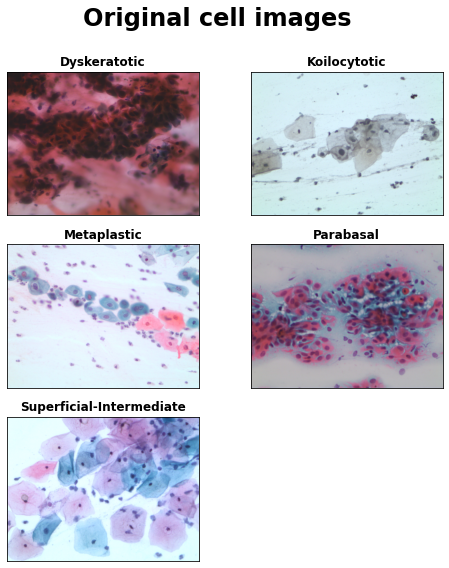

In [ ]:
plot_image_grid(file_dict, image_index=20, title="Original cell images")

### Visualize cropped images

The data set also contains cropped images, which only contain single cells that were extracted after image segmentation. We will use those cropped cell images for training the deep learning classifier.

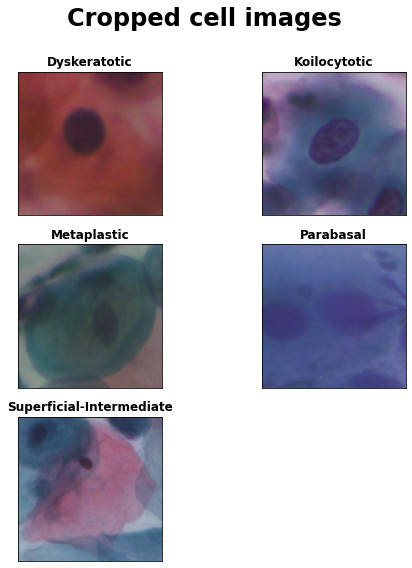

In [ ]:
plot_image_grid(file_cropped_dict, image_index=20, 
                resize=True, title="Cropped cell images")

### Check class balance

It is important to check whether the data set is balanced with regards to the various cell categories. We will use the labels to train the classifier with, so it is important that those are balanced. We will inspect class balance by counting the class labels per cell type in the data set and assessing that all classes have similar proportions in the data set.



In [ ]:
file_dict = {}

for c in CLASSES:
  file_dict[c] = glob.glob(os.path.join(IMAGGE_DIR, c, '*bmp'))

total_nr = sum([len(file_dict[x]) for x in file_dict.keys()])
print(f"Total nr of images found: {total_nr}")
for k,v in file_dict.items():
  nr_per_class = len(file_dict[k])
  print(f"Class '{k}': {nr_per_class} ({(nr_per_class * 100 // total_nr):.2f}%) images found")

Total nr of images found: 966
Class 'Dyskeratotic': 223 (23.00%) images found
Class 'Koilocytotic': 238 (24.00%) images found
Class 'Metaplastic': 271 (28.00%) images found
Class 'Parabasal': 108 (11.00%) images found
Class 'Superficial-Intermediate': 126 (13.00%) images found


In [ ]:
file_cropped_dict = {}

for c in CLASSES:
  file_cropped_dict[c] = glob.glob(os.path.join(
                            CROPPED_DIR, c, '*bmp'))
  
total_cropped_nr = sum([len(file_cropped_dict[x]) for x in file_cropped_dict.keys()])
print(f"Total nr of cropped images found: {total_cropped_nr}")
for k,v in file_cropped_dict.items():
  nr_per_class = len(file_cropped_dict[k])
  print(f"Class '{k}': {nr_per_class} ({(nr_per_class * 100 // total_cropped_nr):.2f}%) cropped images found")

Total nr of cropped images found: 4049
Class 'Dyskeratotic': 813 (20.00%) cropped images found
Class 'Koilocytotic': 825 (20.00%) cropped images found
Class 'Metaplastic': 793 (19.00%) cropped images found
Class 'Parabasal': 787 (19.00%) cropped images found
Class 'Superficial-Intermediate': 831 (20.00%) cropped images found


We can see that the classes are fairly balanced in the cropped images. Since we will use only those cropped images for training the model, no further adjustments with regards to class balance need to be made.

## Data set loading

After visual inspection of assessment of class balance, we will import the data set with cropped images for futher analysis. Keras provides some utilities to load the data set directly from a hierarchical directory, where each cell category is placed in a separate subfolder.

Furthermore, we will split the data set into a training, validation and test set. We will use the training and validation sets for fitting model weights and tuning hyperparameters, while the test set will only be used for evaluating model performance of the trained network.

### Create training, validation and test batches

In [ ]:
BATCH_SIZE = 32

train_ds = keras.utils.image_dataset_from_directory(
    directory=CROPPED_DIR,
    subset='training',
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    shuffle=True,
    seed=42,
    batch_size=BATCH_SIZE,
    image_size=(256, 256))

validation_ds = keras.utils.image_dataset_from_directory(
    directory=CROPPED_DIR,
    subset='validation',
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    shuffle=True,
    seed=42,
    batch_size=BATCH_SIZE,
    image_size=(256, 256))

Found 4049 files belonging to 5 classes.
Using 3240 files for training.
Found 4049 files belonging to 5 classes.
Using 809 files for validation.


In [ ]:
class_names = train_ds.class_names
print("Class names found in training data set:")
for i,n in enumerate(class_names):
  print(f"{i}. {n}")

Class names found in training data set:
0. Dyskeratotic
1. Koilocytotic
2. Metaplastic
3. Parabasal
4. Superficial-Intermediate


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 102
Number of validation batches: 21
Number of test batches: 5


## Data preprocessing

Before we can feed the data into the nearal network,  we still need to perform some preprocessing. Firstly, we will create an augmentation layer that will apply some transformations on the original images to generate additional training images. Afterwards, all images still need to be further standardized and scaled before feeding them into the neural network, so we will also add a standardization layer

### Performance optimization

To optimize performance of the data preprocessing pipeline, Tensorflow provides a software pipelining mechanism through the `tf.data.Dataset.prefetch` transformation that will use a background thread to prefetch elements from the input data set ahead of the time they are requested. So during data preprocessing, this utitlity will prefetch and offload data loading, augmentation and scaling to a background thread, which will improve performance.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create data augmentation layer

To increase the nummer of images available for training the model, we will create a data augmentation layer. This data augmentation layer will generate extra training images by flipping and randomly rotating the original training images.

Importantly, note that we will not apply any color-changing transformations during this data augmentation step, because the colors in the images are induced by cell staining and convey crucial information about cell status.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomRotation(0.4)
])

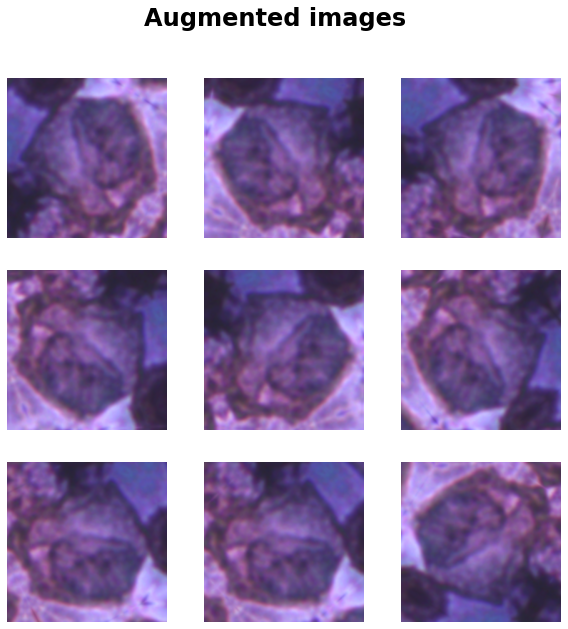

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  plt.suptitle("Augmented images", fontsize=24, fontweight='bold')
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Create preprocessing layer

Additionally, we will create a preprocessing layer that will standardize and scale all values of an image array between [-1, 1] before feeding the output into the Xception layers. This functionality is provided by the method `preprocess_input` in the `mobilenet_v2` module.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Creation base model

### Download Xception network architecture

To create a base model, we will download the Xcption model via the Keras API using `keras.applications.Xception`. Note that we can specify to download pretrained weights by setting parameter `weights='imagenet'`. Those weights were obtained by training the Xception network on the *imagenet* data set **[Deng et al., 2018]**. We will then perform transfer learning by initializing the network with those pretained Xception weights trained om Imagenet and then to repurpose the network for a new classification task. To preserve the pretrained weights and to make sure they are not overwritten during training of the new classiication layer, we set parameter `base_model.trainable=False`.

When we set parameter `include_top=False`, the final classification layer of the Xception network is not included in the network architecture. So we will add a new, final classification layer ourselves to the headless Xception network and train this output layer on the SIPaKMeD data set.

In [ ]:
base_model = keras.applications.Xception(
    input_shape=(256, 256, 3), 
    weights='imagenet',
    include_top=False) 

base_model.trainable = False

83683744/83683744 [==============================] - 0s 0us/step


We can test whether the network architecture works by providing an input batch containing images of 256 by 256 with 3 color channels (e.g. also see the input parameter  `input_shape=(256,256,3)` to the Xception base model. The network will then return a feature vector of shape `(32, 8, 8, 2048)`. The first dimension denotes the batch size, whereas the remaining (8.8.2048) dimension is the result of applying various convolution operations by the Xception network architecture. So we will still need to add a new classification to the headless Xception network that will use this feature vector to classify the cervical cell types.

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 2048)


### Define new network architecture

We can extend the headless Xception network architecture using the Keras functional API.

We will add he preprocessing and data augmentation layers as follows:
```
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
```

After we have added the base model layers and before the next `Dense` layer, we will add a `Dropout` layer for regularization and to avoid overfitting. Note that we have specified several dropout rates. Those will get tested automatically during hyperparameter optimization.
```
hp_dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.3] )
x = tf.keras.layers.Dropout(rate=hp_dropout_rate)(x)
```

After we have added the `Dropout` layer, we will add a `Dense` hidden layer, which will flatten the (32, 8, 8, 2048) dimensional tensor to a feature vector which subsequently will be used by the final layer for classification. Similar to the `Dropout` layer, we have specified several values for the number of hidden units, which will automatically get tested during hyperparameter optimization. This hidden `Dense` layer has a relu activation function.

```
hp_units = hp.Int('units', min_value=128, max_value=256, step=64)
x =  tf.keras.layers.Dense(units=hp_units, activation='relu')(x)
```
After we have added all preprocessing and internal layers, will add the final output layer that will perform the predictions. This output layer has 5 unit because there are 5 cell categories that it will predict. As an activation function, we will use a softmax function, which will output a vector of length 5 containing probabilities for each cell category.

```
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)
ax')(x)
```
Besides adding some extra layers, we will also add ADAM **[Kingma & Ba, 2014]** as the stochastic optimization algorithm that will be used to learn the weights of the new network during training.

```
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)
```

Additionally, we also define some metrics that will be useful to evaluate model performance during training. 

In [ ]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),
    keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
    keras.metrics.CategoricalCrossentropy(name='categorical_crossentropy')
]

In [ ]:
def model_builder(hp):

  inputs = tf.keras.Input(shape=(256, 256, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  
  hp_dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.3] )
  x = tf.keras.layers.Dropout(rate=hp_dropout_rate)(x)

  hp_units = hp.Int('units', min_value=128, max_value=256, step=64)
  x =  tf.keras.layers.Dense(units=hp_units, activation='relu')(x)

  predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

  model = tf.keras.models.Model(inputs=inputs, outputs=predictions)

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)
  
  return model


## Hyperparameter search

We will use KerasTuner **[Malley, 2019]** to find the optional dropout rate for the dropout layer and the optimal number of nodes for the hidden, dense layer. To find these parameters, KerasTuner will perform a hyperparameter search using the `Hyperband` algorithm **[Li at al, 2017]**.

In [ ]:
KT_NR_EPOCHS = 10

tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=KT_NR_EPOCHS,
                     factor=3,
                     directory='keras_tuner',
                     project_name='kt_cervical_classifier')

To reduce training time, we will define a Keras callback that will stop the training once the validation loss does not decrease after 3 epochs. The callback will also store the weights of the best model.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              mode='min', 
                                              patience=3, 
                                              verbose=1, 
                                              restore_best_weights=True)

The following code will peform the hyperparameter search and return the best dropout rate and number of hidden nodes.

In [ ]:
tf.get_logger().setLevel('ERROR')

tuner.search(train_ds, 
             validation_data=validation_ds, 
             epochs=KT_NR_EPOCHS, 
             callbacks=[early_stop])


best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hypersearch finished.\n
Best dropout rate: {best_hps.get('dropout_rate')}.
Best nr of units: {best_hps.get('units')}
""")


Hypersearch finished.

Best dropout rate: 0.3.
Best nr of units: 256



## Model fitting

After the best drouput rate and number of hidden units for the hidden layer have been found by the hyperparameter search, we can retrieve the best network model, initialized with those best parameters. We will then use this best network for further model fitting during the training phase. 

### Train top layer base model

We can retrive the best model as identified during the hyperparameter search as follows:

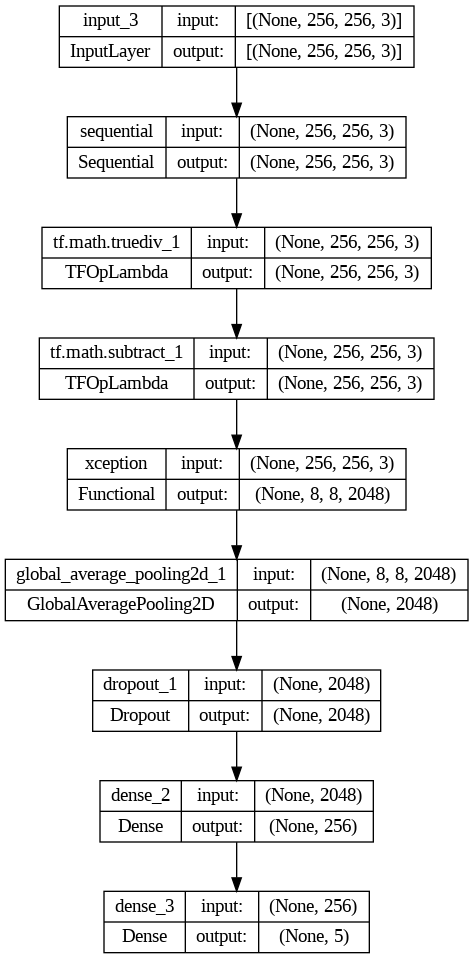

In [ ]:
best_model = tuner.hypermodel.build(best_hps)
keras.utils.plot_model(best_model, show_shapes=True)

In [ ]:
NR_EPOCHS = 50

history = best_model.fit(train_ds, 
                          batch_size = BATCH_SIZE, 
                          epochs=NR_EPOCHS, 
                          validation_data=validation_ds, 
                          callbacks=[early_stop])

Epoch 1/30
102/102 [==============================] - 541s 5s/step - loss: 0.5825 - fn: 880.0000 - fp: 412.0000 - tn: 12548.0000 - tp: 2360.0000 - precision: 0.8514 - recall: 0.7284 - auc: 0.9564 - prc: 0.8747 - categorical_accuracy: 0.7892 - categorical_crossentropy: 0.5825 - val_loss: 0.3851 - val_fn: 104.0000 - val_fp: 72.0000 - val_tn: 2524.0000 - val_tp: 545.0000 - val_precision: 0.8833 - val_recall: 0.8398 - val_auc: 0.9810 - val_prc: 0.9369 - val_categorical_accuracy: 0.8598 - val_categorical_crossentropy: 0.3851
Epoch 2/30
102/102 [==============================] - 25s 247ms/step - loss: 0.3886 - fn: 517.0000 - fp: 368.0000 - tn: 12592.0000 - tp: 2723.0000 - precision: 0.8809 - recall: 0.8404 - auc: 0.9792 - prc: 0.9356 - categorical_accuracy: 0.8636 - categorical_crossentropy: 0.3886 - val_loss: 0.2862 - val_fn: 72.0000 - val_fp: 54.0000 - val_tn: 2542.0000 - val_tp: 577.0000 - val_precision: 0.9144 - val_recall: 0.8891 - val_auc: 0.9893 - val_prc: 0.9637 - val_categorical_acc

We will also define some auxiliary functions to visualize evolution of performance metrics during training:

In [ ]:
def get_metrics(history):

    metrics_dict = {}

    tpr = np.array(history.history['tp']) / (np.array(history.history['tp']) + np.array(history.history['fn']))
    fpr = np.array(history.history['fp']) / (np.array(history.history['fp']) + np.array(history.history['tp']))

    val_tpr = (
        np.array(history.history['val_tp']) / 
        (np.array(history.history['val_tp']) + np.array(history.history['val_fn']))
    )

    val_fpr = (
        np.array(history.history['val_fp']) / 
        (np.array(history.history['val_fp']) + np.array(history.history['val_tp']))
    )

    metrics_dict['true positive rate'] = (tpr, val_tpr)
    metrics_dict['false_positive_rate'] = (fpr, val_fpr)
    metrics_dict['precision'] = (history.history['precision'], 
                                 history.history['val_precision'])
    metrics_dict['recall'] = (history.history['recall'], 
                              history.history['val_recall'])
    metrics_dict['loss'] = (history.history['loss'], 
                             history.history['val_loss'])
    metrics_dict['auc'] = (history.history['auc'], 
                           history.history['val_auc'])
    metrics_dict['categorical_crossentropy'] = (history.history['categorical_crossentropy'], 
                                                history.history['val_categorical_crossentropy'])
    metrics_dict['categorical_accuracy'] = (history.history['categorical_accuracy'], 
                                            history.history['val_categorical_accuracy'])
    return metrics_dict

In [ ]:
def plot_metrics(metrics, size_factor=4):
  
    assert type(metrics)==dict
    n_rows = round(len(metrics.keys())/2)
    plt.subplots(n_rows, 2, figsize=(n_rows * size_factor,n_rows * size_factor))
    for i, (k,v) in enumerate(metrics.items()):
        plt.subplot(n_rows,2,i+1)
        plt.plot(v[0])
        plt.plot(v[1], linestyle="--")
        plt.title(k, fontweight="bold")
        if (k != "loss" and k != "binary_crossentropy"):
            plt.ylim(0,1)
        plt.ylabel(k)
        if i+1==(n_rows*2) or i+1==(n_rows*2 -1):
            plt.xlabel('epoch')
        plt.legend(labels=['Train', 'Validation'])

The following graphs provide some visualization of the metrics defined earlier during the training process. We can observe that the loss indeed goes down in the training and test set. 

The best classifier was fitted in epoch 9 with the following performance metrics calculated on the validation set:

* precision: 0.9111
* recall: 0.8998
* auc: 0.9933

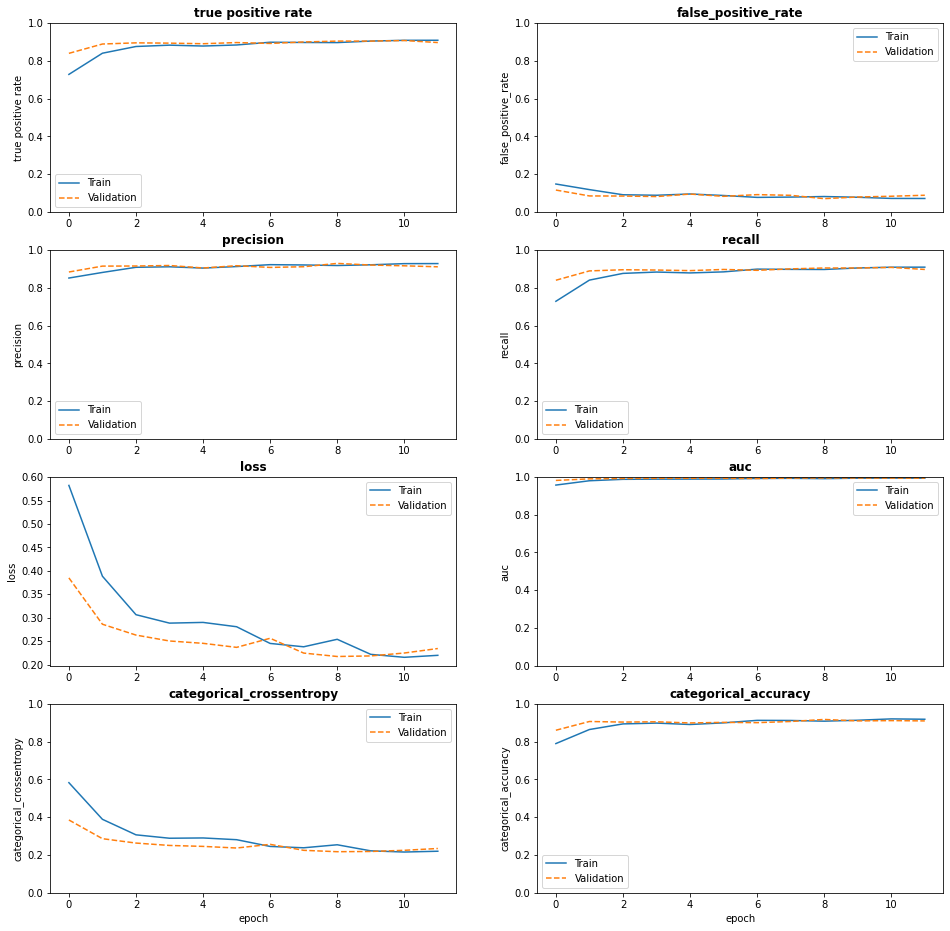

In [ ]:
metrics_dict = get_metrics(history=history)
plot_metrics(metrics=metrics_dict)

### Further fine-tuning of the thransfer model

To further improve model performance, we can fine-tune the previous model. In order to perform fine-tuning of the network, we will freeze the Xception layers and then retrain all layers of the previous model. Importanly, we will use a very small learning rate (1e-4) to prevent overfitting.

We can persist the trained, best network model, by defining a Keras callback that will checkpoint the model and store the best weights with the lowest validation loss.

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_final.h5', 
                                                        monitor='val_loss', 
                                                        mode='min',
                                                        save_weights_only=True,
                                                        save_best_only=True)

In [ ]:
base_model.trainable = True

opt = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

best_model.compile(optimizer=opt, 
                   loss='categorical_crossentropy', 
                   metrics=metrics)

history_ft = best_model.fit(train_ds, 
                            batch_size = BATCH_SIZE, 
                            epochs=NR_EPOCHS, 
                            validation_data=validation_ds, 
                            callbacks=[early_stop, model_checkpoint])

Epoch 1/30
102/102 [==============================] - 99s 914ms/step - loss: 0.1230 - fn: 204.0000 - fp: 168.0000 - tn: 15736.0000 - tp: 3772.0000 - precision: 0.9574 - recall: 0.9487 - auc: 0.9974 - prc: 0.9913 - categorical_accuracy: 0.9535 - categorical_crossentropy: 0.1244 - val_loss: 0.1281 - val_fn: 36.0000 - val_fp: 32.0000 - val_tn: 2564.0000 - val_tp: 613.0000 - val_precision: 0.9504 - val_recall: 0.9445 - val_auc: 0.9977 - val_prc: 0.9913 - val_categorical_accuracy: 0.9492 - val_categorical_crossentropy: 0.1281
Epoch 2/30
102/102 [==============================] - 90s 886ms/step - loss: 0.1193 - fn: 159.0000 - fp: 131.0000 - tn: 12829.0000 - tp: 3081.0000 - precision: 0.9592 - recall: 0.9509 - auc: 0.9977 - prc: 0.9920 - categorical_accuracy: 0.9552 - categorical_crossentropy: 0.1193 - val_loss: 0.1255 - val_fn: 31.0000 - val_fp: 29.0000 - val_tn: 2567.0000 - val_tp: 618.0000 - val_precision: 0.9552 - val_recall: 0.9522 - val_auc: 0.9979 - val_prc: 0.9922 - val_categorical_ac


We can observe that there still is an increase in performance.

The best model was found in epoch 10, with the following metrics calculated on the validation set:

* precision: 0.9690
* recall: 0.9646
* val_auc: 0.9991

This is indeed a further improvement still compared to the base model.


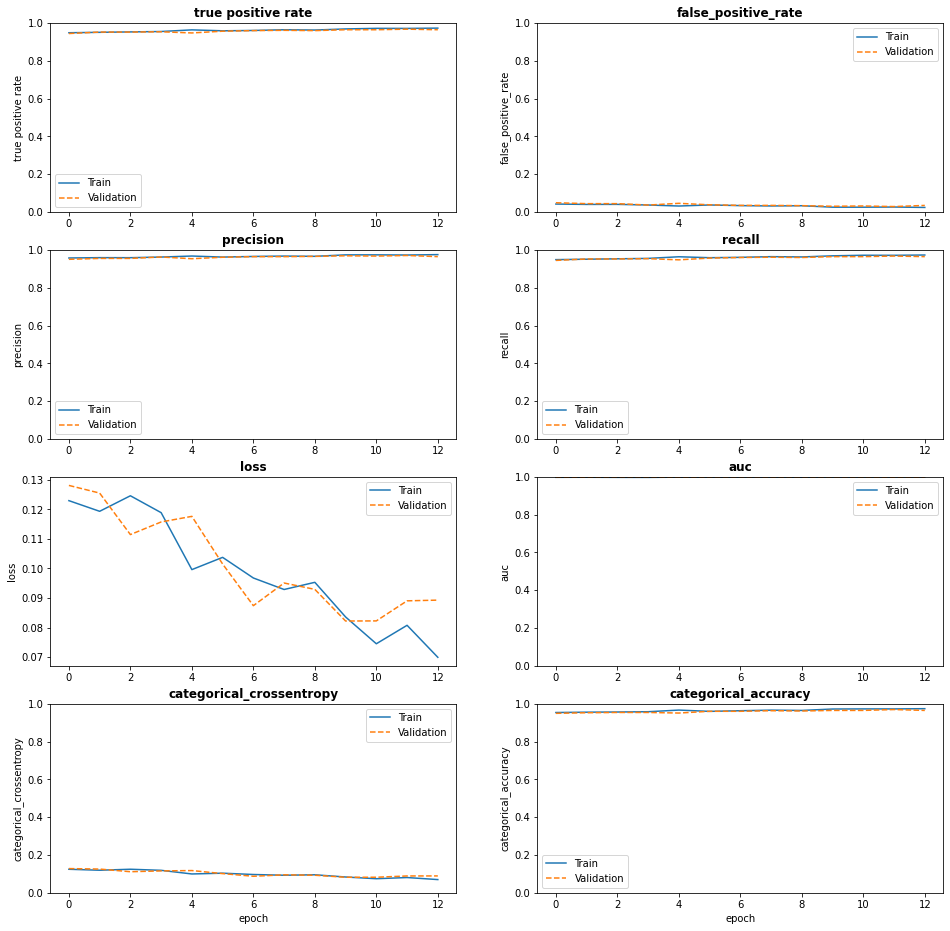

In [ ]:
metrics_dict_ft = get_metrics(history=history_ft)
plot_metrics(metrics=metrics_dict_ft)

## Evaluation Model performance

To get an unbiased estimate of actual model performance, we will evaluate the final model on the test data set to asssess how well the final model performs on previously unseen data. The test data set was held out during model training and not presented to the model before.



### Model evaluation

We can obtain performance metrics for the final model on the test data set as follows:

In [ ]:

print("Evaluate model on test data")
test_results = best_model.evaluate(test_ds, batch_size=BATCH_SIZE)
test_metrics = ("loss", "fn", "fp", "tn", "tp", 
                "precision", "recall", "auc", "prc",
                "categorical_accuracy", "categorical_crossentropy")

print("\n\nPerformance final model on test data:\n")
test_dict = {test_metrics[i]: test_results[i] for i in range(len(test_metrics))}

for k,v in test_dict.items():
  print(k,":",v)

Evaluate model on test data
5/5 [==============================] - 1s 175ms/step - loss: 0.1548 - fn: 9.0000 - fp: 9.0000 - tn: 631.0000 - tp: 151.0000 - precision: 0.9438 - recall: 0.9438 - auc: 0.9950 - prc: 0.9895 - categorical_accuracy: 0.9438 - categorical_crossentropy: 0.1548


Performance final model on test data:

loss : 0.15478989481925964
fn : 9.0
fp : 9.0
tn : 631.0
tp : 151.0
precision : 0.9437500238418579
recall : 0.9437500238418579
auc : 0.9949658513069153
prc : 0.9894886016845703
categorical_accuracy : 0.9437500238418579
categorical_crossentropy : 0.15478989481925964


The computed metrics for the test data set are actually slightly better than the training set, so the model seems to generalize well.

### Model predictions

We can use the final model to predict class labels for individual images in the test data set and compare those predicted labels with the actual test labels as follows:

In [ ]:
y_test = [np.argmax(y, axis=1).tolist() for _, y in test_ds]
y_test = [class_names[item] for sublist in y_test for item in sublist]

y_pred = np.argmax(best_model.predict(test_ds), axis=1).tolist()
y_pred = [class_names[x] for x in y_pred]

5/5 [==============================] - 1s 179ms/step


We can plot some entires, along with their actual and predicted labels, t visually inspect the predictions made by the network.

In [ ]:
def plot_predictions(ds=test_ds, classes=y_test, predicted=y_pred):
  for image, label in test_ds.take(1):
    plt.figure(figsize=(10, 10))
    plt.suptitle("Model predictions", fontsize=24, fontweight='bold')
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      label = f"Class       : {classes[i]}\nPredicted: {predicted[i]}"
      plt.xlabel(label)
      plt.imshow(image[i] / 255)
      plt.tick_params( 
        axis='both',
        which='both',
        bottom=False,
        top=False,
        left=False,
        labelleft=False,
        labelbottom=False)
    

From the plot with model predictions we can observe that the model correctly predicts 8 from the 9 selected images. The only incorrectly predicted class is for the middle image, where a Kolcytotic cell is incorrectly classified as a Dyskeratotic cell.

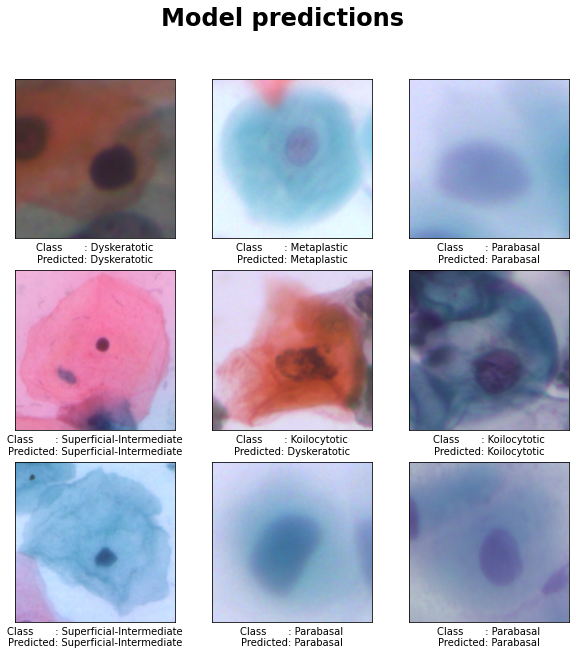

In [ ]:
plot_predictions(ds=test_ds, classes=y_test, predicted=y_pred)

### Confusion Matrix

We can obtain a more comprehensive view of classifier performance by generating the confusion matrix for all 5 classes.

We can observe from the confusion matrix that most samples are correctly classified (i.e. high counts for the true positives in the diagonal, and several entries containing zeros in the other cells).

Furthermore, we can observe that most incorrect classifcations are for Kolocytotic cells, so to further improve performance of the classifier we could train the network with more Kolocytotic cell images.


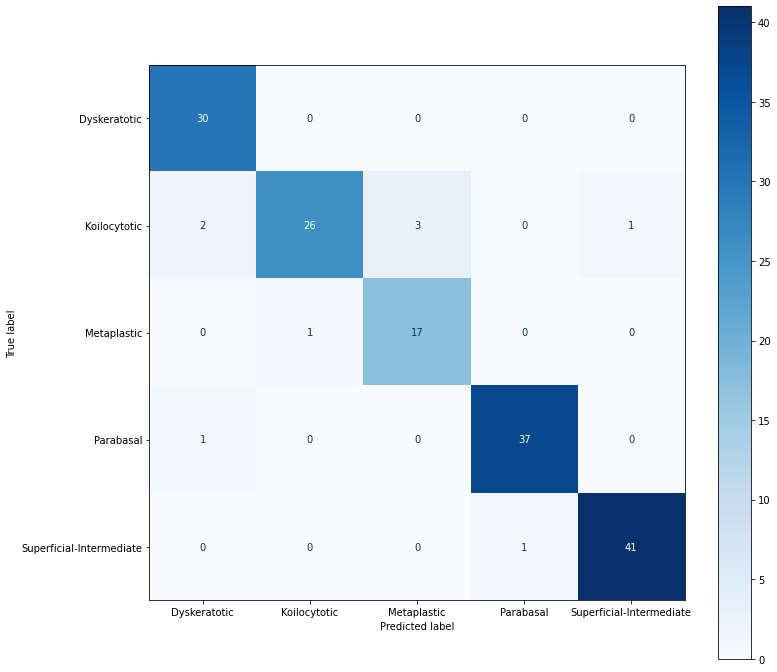

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=class_names)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(12,12))
cm_disp.plot(ax=ax, cmap=plt.cm.Blues);

Finally, let's save the analysis to an HTML report.

In [ ]:
!jupyter nbconvert --to html cervical_cancer.ipynb

[NbConvertApp] Converting notebook cervical_cancer.ipynb to html
[NbConvertApp] Writing 2244282 bytes to cervical_cancer.html


## References

* **Chollet, F** (2017). Xception: Deep learning with depthwise separable convolutions. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1251-1258).

* **Deng, J., Dong, W., Socher, R., Li, L. J., Li, K., & Fei-Fei, L**. (2009, June). Imagenet: A large-scale hierarchical image database. In 2009 IEEE conference on computer vision and pattern recognition (pp. 248-255). Ieee.

* **Kingma, D. P., & Ba, J** (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.

* **Li, L., Jamieson, K., DeSalvo, G., Rostamizadeh, A., & Talwalkar, A. (2017)**. Hyperband: A novel bandit-based approach to hyperparameter optimization. The Journal of Machine Learning Research, 18(1), 6765-6816.

* **Malley, T., Bursztein, E., Long, J. Chollet, F., Jin, H.,  Invernizzi, L and others** Keras Tunre (2019) [https://github.com/keras-team/keras-tuner](https://github.com/keras-team/keras-tuner)

* **Plissiti, M. E., Dimitrakopoulos, P., Sfikas, G., Nikou, C., Krikoni, O., & Charchanti, A**. (2018, October). SIPAKMED: A new dataset for feature and image based classification of normal and pathological cervical cells in Pap smear images. In 2018 25th IEEE International Conference on Image Processing (ICIP) (pp. 3144-3148). IEEE. [https://www.cs.uoi.gr/~marina/sipakmed.html](https://www.cs.uoi.gr/~marina/sipakmed.html)



